In [32]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
# Classe que importa os dados gerados em gerador-de-dadosPINN.ipynb
# Decidi não importar os valores das constantes, como ω e β por enquanto(preferi evitar mais algumas colunas na tabela e manter simplesmente a função x(t) para facilitar o entendimento). \
# Logo, para o treinamento PINN, reescrevi esses valores (hardcoding) antes de treinar a rede, mas pretendo mudar isso no futuro. 
# Exemplo:
#   α=2.0
#   ω=8.0
#   k=ω²

# device padrão: CPU.

class Data():
    def __init__(self, filename):
        data = pd.read_pickle(filename)
        d_time = data.drop(columns=['X'])
        d_pos  = data.drop(columns=['T'])
        t = d_time.iloc[:, :].values
        x =  d_pos.iloc[:, :].values

        self.t = torch.tensor(t, requires_grad=True, dtype=torch.float)
        self.x = torch.tensor(x, requires_grad=True, dtype=torch.float)

    def __len__(self):
        return len(self.t)
    
    def __getparams__(self):
        return self.t, self.x

    def __getitem__(self, idx):
        return self.t[idx], self.x[idx]


data  = Data('training-oha.pkl')  
vdata = Data('validation-oha.pkl') 
# Diferentemente dos treinamentos passados, neste eu mudei os nomes das variáveis. O "x" virou "t", e o "y" virou "x". Sendo assim, representa melhor a função x(t) do problema.
# Isso me confundiu algumas vezes nos códigos passados, então decidi mudar neste. No entanto, isso não muda em nada os resultados obtidos, tanto desse, como dos outros experimentos.

# Ou seja,
#     y(x) -> x(t)
#   data.x -> data.t
#   data.y -> data.x


print(f"Número de dados de treinamento: {data.__len__()}")
print(f"Número de dados de validação: {vdata.__len__()}")

Número de dados de treinamento: 20
Número de dados de validação: 100


In [34]:
class OHAModel(nn.Module):
    def __init__(self):
        super(OHAModel, self).__init__()
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 1)) # 1 InputL, 32 HiddenL, 1 OutputL. Estrutura da Rede Neural

    def forward(self, t):
        out = self.linear(t)
        return out

model = OHAModel()
print("Estrutura da rede neural: \n")
print(model)

Estrutura da rede neural: 

OHAModel(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [35]:
optimiser = torch.optim.Adam(model.parameters()) # Otimizador do modelo

In [36]:
# Custom loss function:
# Função base:

class OHALoss(nn.Module):
    def __init__(self):
        super(OHALoss, self).__init__()

    def df(self, output : torch.Tensor, t: torch.Tensor = None, order : int=1) -> torch.Tensor: # Principal elemento de uma PINN. Aqui é onde a auto-diferenciação funciona.
        for _ in range(order):
            output = torch.autograd.grad(output, t, grad_outputs=torch.ones_like(t), create_graph=True, retain_graph=True)[0]
            
        return output


    def forward(self, t_physics : torch.Tensor, physics_output : torch.Tensor, output : torch.Tensor, target : torch.Tensor, coef, k):
        # DE contribution
        LossDE = self.df(physics_output, t_physics, order=2) + (coef)*self.df(physics_output, t_physics, order=1) + (k)*physics_output # Entender a razão do erro em coef. variáveis.

        #MSE loss
        LossMSE = (target - output)

        Loss = LossMSE.pow(2).mean() + LossDE.pow(2).mean() # Para entender como a rede se comporta caso utilize o treinamento tradicional(MSE), colocar o "#" antes do "+" em "+ LossDE...".

        return Loss





In [37]:
loss_func = OHALoss()
t_physics = torch.linspace(0.01, 5, 900, requires_grad=True).view(-1,1) # Domínio: R[0.01, 5]

# t_physics determina o domínio da função que a rede pode prever. Desse modo, caso haja necessidade de uma previsão com t > 5, a rede não será capaz de definir \
# e outro treinamento deverá ser realizado

w0 = 8.00
alpha = 2.00
coef = (alpha/t_physics).clone().detach().requires_grad_(True) # Coeficiente variável de acordo com o tempo / análogo ao coeficiente de atrito μ(t)
# O coeficiente variável é a principal causa do problema atual.
# Encontrar um jeito de utilizar o autograd e LossDE com ele.

k  = pow(w0, 2)

epochs = 10000
for epoch in range(epochs):
    optimiser.zero_grad() 

    physics_outputs = model(t_physics) # Previsão da rede necessária para melhor eficiência do autograd. Possui dimensão de 900 passos por previsão.


    output = model(data.t) # Retorno da rede quando colocada em função dos dados gerados (possui a mesma dimensão e tamanho para ser comparada \    
    # ao target da rede na loss MSE.

    loss = loss_func(t_physics, physics_outputs, output, data.x, coef, k)
    
    loss.backward()
    optimiser.step()
    
    if epoch % 1000 == 0:
         with torch.autograd.no_grad():
            print(f"Epoch: {epoch} - Loss: {float(loss.item()):>7f}")


Epoch: 0 - Loss: 364.048859


Epoch: 1000 - Loss: 0.125390
Epoch: 2000 - Loss: 0.123773
Epoch: 3000 - Loss: 0.122445
Epoch: 4000 - Loss: 0.121473
Epoch: 5000 - Loss: 0.121055
Epoch: 6000 - Loss: 0.120976
Epoch: 7000 - Loss: 0.120971
Epoch: 8000 - Loss: 0.121181
Epoch: 9000 - Loss: 0.120970


In [38]:
torch.save(model.state_dict(), "model.pth") # Salva o modelo para usos futuros.
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


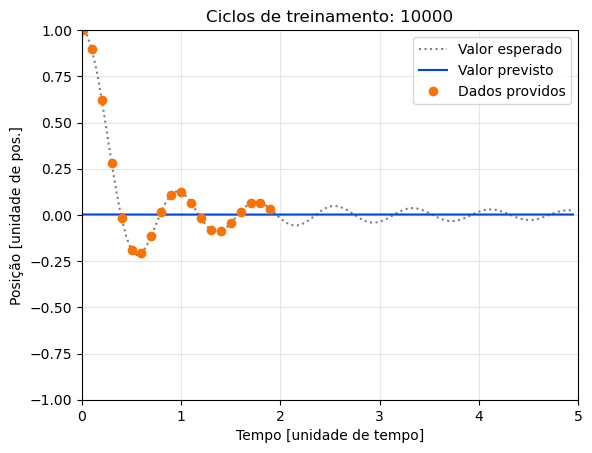

In [41]:
model = OHAModel()
model.load_state_dict(torch.load("model.pth"))

predicted = model(vdata.t).detach().numpy() # Previsão da rede.

# Passando os dados para numpy a fim de imprimir o gráfico.
vt = vdata.t.detach().numpy()
vx = vdata.x.detach().numpy()

t = data.t.detach().numpy()
x = data.x.detach().numpy()

plt.plot(vt, vx, color='tab:gray', linestyle=':', label='Valor esperado')
plt.plot(vt, predicted, color='xkcd:blue', linestyle='solid', label = 'Valor previsto')
plt.plot(t, x, color='xkcd:orange', marker='o', linestyle='none', label = 'Dados providos')
plt.xlim([0, 5])
plt.ylim([-1, 1])
plt.title(f'Ciclos de treinamento: {epochs}')
plt.xlabel('Tempo [unidade de tempo]')
plt.ylabel('Posição [unidade de pos.]')
plt.legend(loc=1)
plt.grid(True, alpha=0.3)
plt.savefig('grafico-oha.jpg', dpi=150)
plt.show()

# Cálculo do erro

In [40]:
previsto = predicted[:101]
esperado = vdata.x.detach().numpy()[:101]

erro = previsto - esperado
erro_maximo = erro[np.argmax(erro)][0]

print(f'Erro máximo encontrado na rede: {erro_maximo :.4f}')

erro_medio = np.mean(erro)

print(f'Erro médio encontrado na rede: {erro_medio :.4f}')

erro_quadratico_medio = np.power(erro, 2)
erro_quadratico_medio = np.mean(erro_quadratico_medio)

print(f'Erro quadrático médio encontrado na rede: {erro_quadratico_medio :.4f}')

Erro máximo encontrado na rede: 0.2184
Erro médio encontrado na rede: -0.0425
Erro quadrático médio encontrado na rede: 0.0437
